# Create Intake Datastore to hold output from one experiment

This is a minimum example to create a datastore to access output from your experiment.

We use _datastore_ as the name of (one run of) an experiment in an intake catalogue.

If you have more than one experiment but they are temporary, do this procedure more than once. If you are keeping the data long term, then it should go into the main access-nri-intake-catalog (or as a minimum, build your own catalog).

Requirements: The conda/analysis3 module from /g/data/hh5/public/modules. (Example used `conda/analysis3-24.01`)

In [1]:
#where is my output
PATH='/scratch/tm70/as2285/experiments/archive/c_grid/'

This is just normal payu experiment archive:

In [2]:
!ls {PATH}

output000  restart000


Show conda/analysis version

In [3]:
! conda env list | grep "*"

base                  *  /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01


Load modules:

In [5]:
from access_nri_intake.source import builders
from access_nri_intake.catalog.manager import CatalogManager

In [6]:
from dask.distributed import Client

In [7]:
client = Client()

In [8]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43075,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:33119,Total threads: 3
Dashboard: /proxy/44787/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:46323,


List available builders

In [9]:
dir(builders)[0:6]

['AccessCm2Builder',
 'AccessEsm15Builder',
 'AccessOm2Builder',
 'AccessOm3Builder',
 'BaseBuilder',
 'Builder']

Choose the builder for your model

In [10]:
%%time

builder = builders.AccessOm3Builder(
    path=PATH
)

CPU times: user 981 µs, sys: 625 µs, total: 1.61 ms
Wall time: 1.61 ms


In [12]:
builder.build()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/builders.py:152: UserWarning: Unable to parse 1 assets. A list of these assets can be found in `.invalid_assets` attribute.
  self.get_assets().validate_parser().parse().clean_dataframe()


AccessOm3Builder(paths=['/scratch/tm70/as2285/experiments/archive/c_grid/'], storage_options={}, depth=2, exclude_patterns=['*restart*', '*MOM_IC.nc', '*ocean_geometry.nc', '*ocean.stats.nc', '*Vertical_coordinate.nc'], include_patterns=['*.nc'], joblib_parallel_kwargs={'n_jobs': 96})

The warning is ok, we don't expect it to handling coupler output:

In [20]:
builder.invalid_assets

,INVALID_ASSET,TRACEBACK
1,/scratch/tm70/as2285/experiments/archive/c_grid/output000/GMOM_JRA.cpl.hx.ocn.24h.avg.1958-01-02-00000.nc,"Traceback (most recent call last):\n File ""/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/builders.py"", line 329, in parser\n rai..."


Save the datastore to a file (json)

In [21]:
builder.save(name='intake_datastore', description='Prototype OM3 output with C grid enabled in CICE', directory=PATH)

Successfully wrote ESM catalog json file to: file:///scratch/tm70/as2285/experiments/archive/c_grid//intake_datastore.json


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/pydantic/deprecated/decorator.py:222: UserWarning: Unable to parse 1 assets/files. A list of these assets can be found in /jobfs/115715121.gadi-pbs/intake_datastore_invalid_assets.csv.
  return self.raw_function(**d, **var_kwargs)


You can now use this datastore in the normal way:

In [14]:
from intake import open_esm_datastore

In [15]:
datastore = open_esm_datastore(PATH+'intake_datastore.json',columns_with_iterables=["variable"] )

Load aice as the example

In [16]:
aice_ds=datastore.search(variable='aice').to_dask()

In [17]:
aice_ds

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, nj: 300, ni: 360)
Coordinates:
  * time     (time) datetime64[ns] 8B 1958-01-01T12:00:00
    TLON     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    TLAT     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    ULON     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    ULAT     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    NLON     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    NLAT     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    ELON     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
    ELAT     (nj, ni) float64 864kB dask.array<chunksize=(150, 360), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables:
    aice     (time, nj, ni) float64 864kB dask.array<chunksize=(1, 150, 360), meta=np.ndarray>
Attributes: (12/26)
    title:                                    GMOM_JRA
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment2:                                 File written on model date 1958...
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   ['', '', '', '', '', '', '', ''...
    intake_esm_attrs:variable_units:          ['days since 1958-01-01 00:00:0...
    intake_esm_attrs:filename:                GMOM_JRA.cice.h.1958-01-01.nc
    intake_esm_attrs:file_id:                 GMOM_JRA_cice_h_XXXX_XX_XX
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   GMOM_JRA_cice_h_XXXX_XX_XX.1day

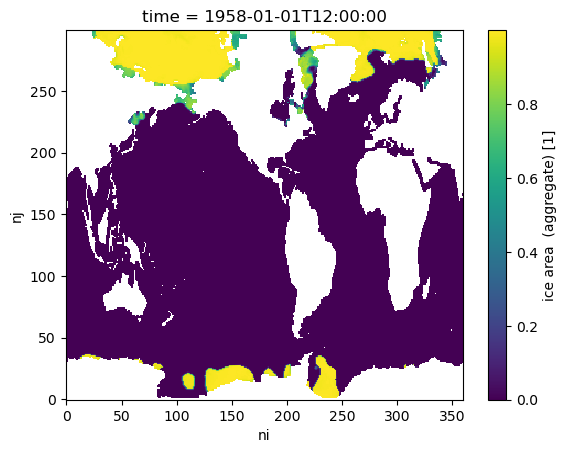

In [18]:
aice_ds.aice.isel(time=0).plot()

In [19]:
client.close()